# **0. Importing Files**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

# **0.1 Data Loading**

In [27]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Load the dataset using pandas
# The dataset contains car advertisement details, including mileage, price, and vehicle specifications.
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/MMU/Assignments/0 Sem 1/Data Science/Files/adverts.csv')

# **1. Data Description and Pre-Processing**

## **1.1 Summary**

**A. Summarize the Dataset**

In [29]:
# Basic information about the dataset
print("Dataset Info:")
data.info()

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())

# Checking missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB

Summary Statistics:
       public_reference        mileage  

**B. Correlation Heatmap**

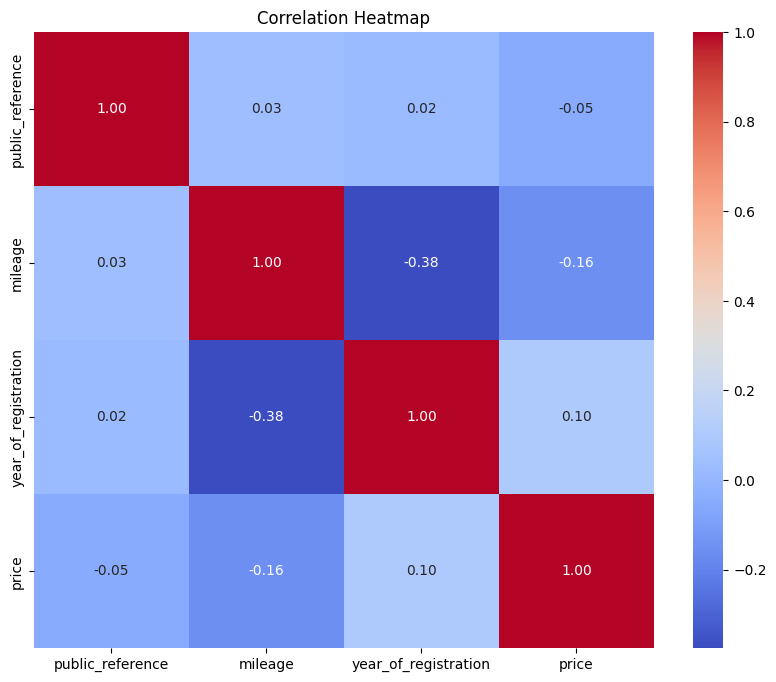

In [30]:
# Exclude non-numerical columns to compute correlation
numerical_data = data.select_dtypes(include=[np.number])

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = numerical_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

**C. Scatter-plot: Price vs Mileage**

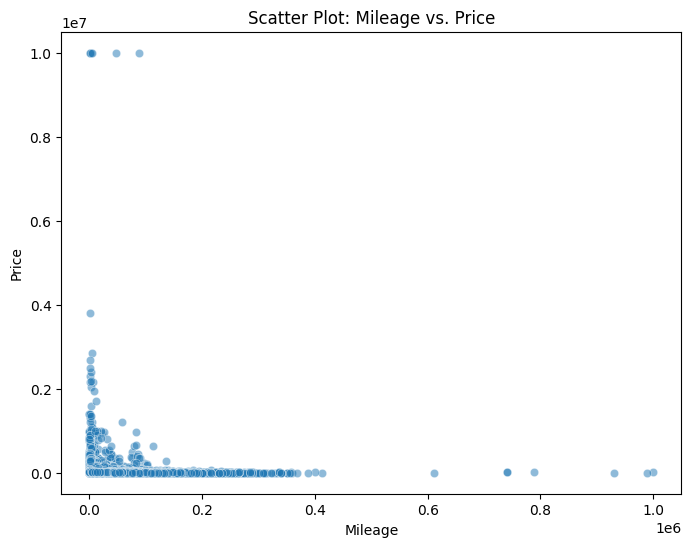

In [31]:
# Scatter plot for mileage vs price
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['mileage'], y=data['price'], alpha=0.5)
plt.title('Scatter Plot: Mileage vs. Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

**D. Visualize missing Values**

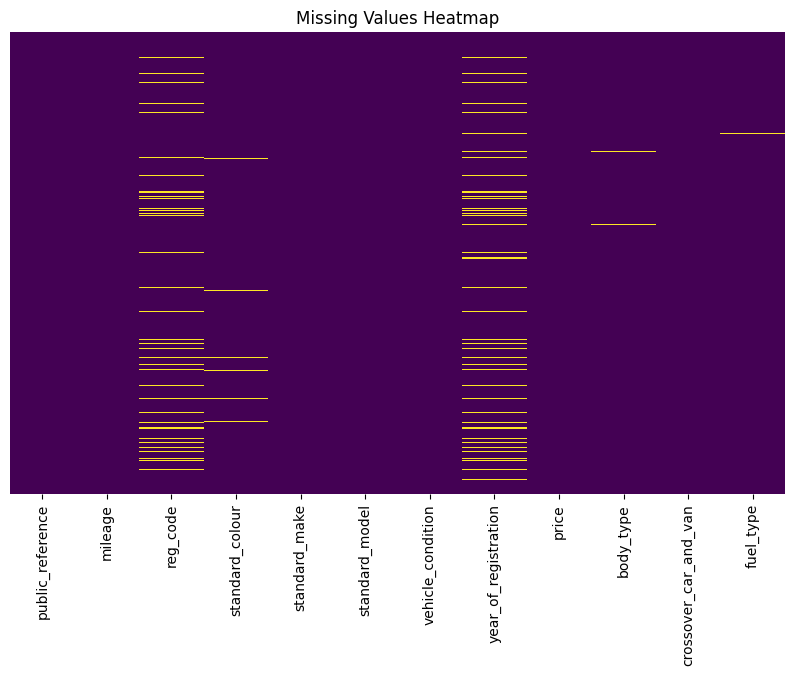

In [32]:
# Visualize missing values as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

**E. Identify Outliers**

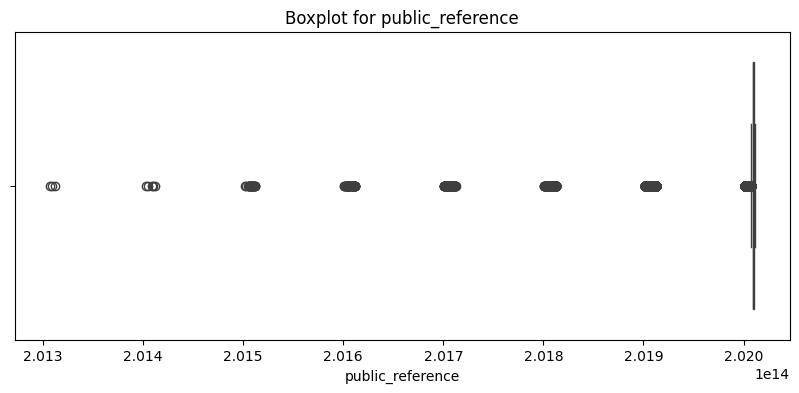

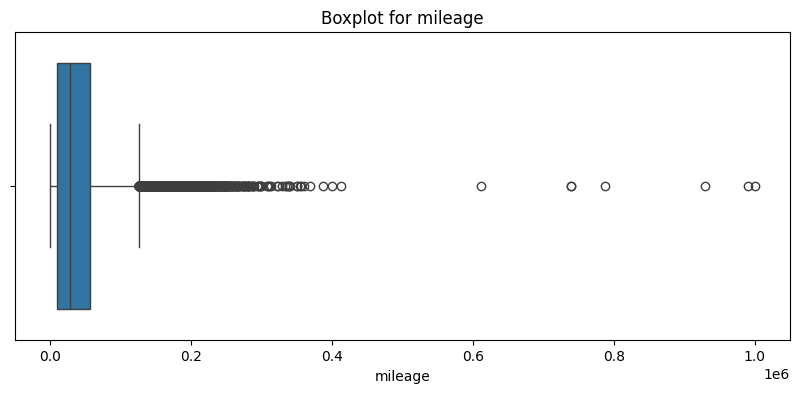

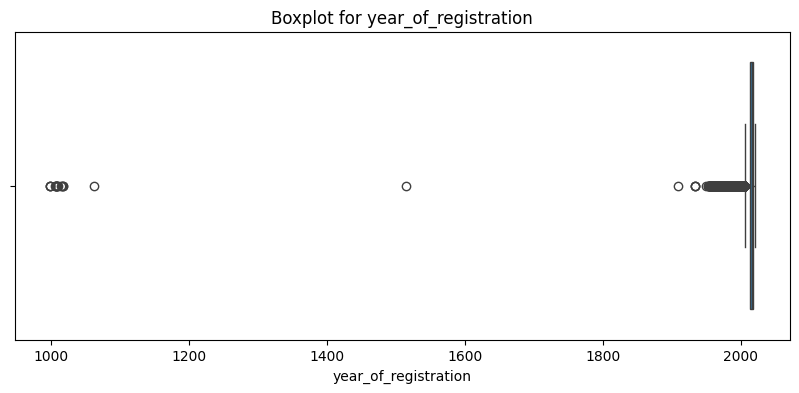

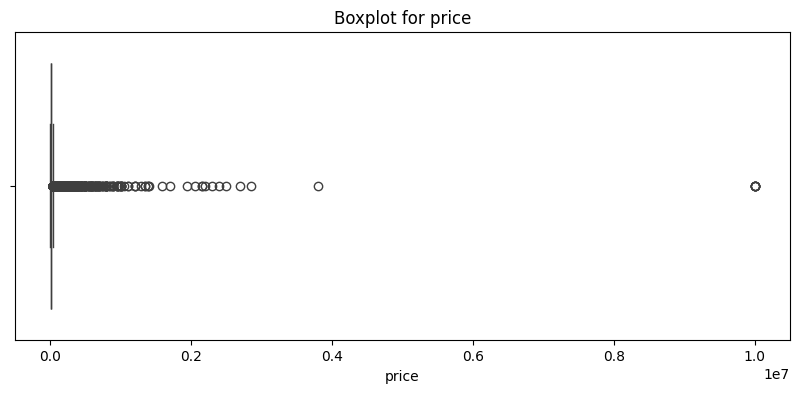

In [33]:
# Boxplot visualization for numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns

for col in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

## ***1.2 Pre-Processing***

***A. Missing Values Handling***

In [34]:
# Fill missing values
numerical_features = ['mileage', 'year_of_registration']
categorical_features = ['fuel_type', 'vehicle_condition', 'body_type', 'reg_code', 'standard_colour']

# Check column names in the DataFrame
print("Columns in DataFrame:")
print(data.columns)

# Fill numerical features with median
for col in numerical_features:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Fill categorical features with 'Unknown'
for col in categorical_features:
    if col in data.columns:
        data[col] = data[col].fillna('Unknown')
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Confirm no missing values remain
print("Remaining Missing Values:")
print(data.isnull().sum())

Columns in DataFrame:
Index(['public_reference', 'mileage', 'reg_code', 'standard_colour',
       'standard_make', 'standard_model', 'vehicle_condition',
       'year_of_registration', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type'],
      dtype='object')
Remaining Missing Values:
public_reference         0
mileage                  0
reg_code                 0
standard_colour          0
standard_make            0
standard_model           0
vehicle_condition        0
year_of_registration     0
price                    0
body_type                0
crossover_car_and_van    0
fuel_type                0
dtype: int64


***B. IQR for Outlier handling***

In [35]:
# Import necessary libraries
import pandas as pd

# Function to detect and address outliers using IQR
def handle_outliers(df, column, remove=True):
    """
    Detect and handle outliers in a given column using the IQR method.

    Parameters:
    - df: DataFrame
    - column: str, the column name to process
    - remove: bool, if True removes outliers; if False, caps them

    Returns:
    - DataFrame: Updated DataFrame with outliers handled
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if remove:
        # Option 1: Remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    else:
        # Option 2: Cap outliers (retain data but limit extreme values)
        df[column] = df[column].clip(lower_bound, upper_bound)

    return df

# **Handle Outliers in 'price' and 'mileage' Columns**
# Option to remove or cap outliers
data = handle_outliers(data, 'price', remove=True)  # Removing outliers
data = handle_outliers(data, 'mileage', remove=True)  # Removing outliers

# Check new dataset size
print("Remaining Rows After Outlier Removal:", data.shape[0])

Remaining Rows After Outlier Removal: 368276


**Sampling the Dataset**

To manage computational resources effectively, we will take a random sample of 8,000 rows from the dataset.

In [36]:
# Sampling the dataset
data_sampled = data.sample(n=8000, random_state=42)

# Confirm the sample size
print("Sampled Data Shape:", data_sampled.shape)

Sampled Data Shape: (8000, 12)


**C. Feature Engineering**

Feature engineering is a crucial step to improve the predictive performance of machine learning models. Here, we will:

1. Create new relevant features from the existing data.
2. Perform clustering to generate new insights.
3. Engineer meaningful interactions between features.

In [37]:
# Create new features
data_sampled['car_age'] = 2025 - data_sampled['year_of_registration']
data_sampled['mileage_per_year'] = data_sampled['mileage'] / data_sampled['car_age']
data_sampled['mileage_per_year'] = data_sampled['mileage_per_year'].replace([np.inf, -np.inf], 0)  # Handle division by zero

# Check the new features
data_sampled[['car_age', 'mileage_per_year']].head()

,car_age,mileage_per_year
316899,7.0,2251.714286
117767,11.0,5818.181818
121994,8.0,4720.125000
391211,9.0,0.000000
292885,9.0,0.000000


**D. Encode Categorical Variables**

We will encode categorical variables using **Target Encoding**.

In [38]:
# Create new features
data_sampled['car_age'] = 2025 - data_sampled['year_of_registration']
data_sampled['mileage_per_year'] = data_sampled['mileage'] / data_sampled['car_age']
data_sampled['mileage_per_year'] = data_sampled['mileage_per_year'].replace([np.inf, -np.inf], 0)  # Handle division by zero

# Check the new features
data_sampled[['car_age', 'mileage_per_year']].head()

,car_age,mileage_per_year
316899,7.0,2251.714286
117767,11.0,5818.181818
121994,8.0,4720.125000
391211,9.0,0.000000
292885,9.0,0.000000


**E. Scale Numerical Features**

We will scale numerical features using **StandardScaler**.

In [39]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['mileage', 'price', 'car_age', 'mileage_per_year']
data_sampled[numerical_cols] = scaler.fit_transform(data_sampled[numerical_cols])

# Check scaled data
data_sampled[numerical_cols].head()

,mileage,price,car_age,mileage_per_year
316899,-0.689011,0.765502,-0.707773,-0.498422
117767,0.866563,-0.621111,0.298927,0.990894
121994,0.020410,-0.801910,-0.456098,0.532358
391211,-1.197303,0.383653,-0.204423,-1.438712
292885,-1.197303,0.552158,-0.204423,-1.438712


**F. Partition the Data**
We will split the dataset into:
1. Training (60%)
2. Validation (20%)
3. Test (20%)

In [40]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data_sampled.drop(columns=['price', 'public_reference'])
y = data_sampled['price']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (4800, 12)
Validation Set Shape: (1600, 12)
Test Set Shape: (1600, 12)


# ***2. Automated Feature Selection***

**A. Recursive Feature Elimination (RFE):** using Random Forest.

In [41]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Recursive Feature Elimination (RFE)
rfe_estimator = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rfe_estimator, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Selected features using RFE
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected Features (RFE):", selected_features_rfe.tolist())

ValueError: could not convert string to float: 'Unknown'

**C. Mutual Information:**

to rank features based on their dependency with the target variable.

In [ ]:
# Mutual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_series = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)

# Visualize mutual information
plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='bar', color='skyblue')
plt.title("Feature Importance (Mutual Information)")
plt.ylabel("Score")
plt.show()

# **3. Tree Ensembles**

***In Tree Ensembles***

We will train and evaluate the following models:

A. **Random Forest**.

B. **XGBoost**.

We will use **RandomizedSearchCV** for hyperparameter tuning for both models.

## **3.1 Models Training**

***Random Forest with RandomizedSearchCV***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': randint(100, 500),  # Number of trees
    'max_depth': randint(5, 20),        # Maximum depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum number of samples to split
    'min_samples_leaf': randint(1, 5),  # Minimum number of samples per leaf
}

# RandomizedSearchCV for Random Forest
rf = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,       # 3-fold cross-validation
    random_state=42,
    n_jobs=-1
)
rf_random_search.fit(X_train, y_train)

# Best parameters and score for Random Forest
print("Best Parameters (Random Forest):", rf_random_search.best_params_)
print("Best Validation R2 Score (Random Forest):", rf_random_search.best_score_)

# Evaluate on validation set
rf_best_model = rf_random_search.best_estimator_
rf_val_pred = rf_best_model.predict(X_val)
print("Random Forest R2 Score (Validation):", r2_score(y_val, rf_val_pred))

***XGBoost with RandomizedSearchCV***

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(100, 500),       # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Learning rate
    'max_depth': randint(3, 15),             # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0],            # Subsample ratio of the training data
    'colsample_bytree': [0.6, 0.8, 1.0],     # Subsample ratio of columns
}

# RandomizedSearchCV for XGBoost
xgb = XGBRegressor(random_state=42)
xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,       # 3-fold cross-validation
    random_state=42,
    n_jobs=-1
)
xgb_random_search.fit(X_train, y_train)

# Best parameters and score for XGBoost
print("Best Parameters (XGBoost):", xgb_random_search.best_params_)
print("Best Validation R2 Score (XGBoost):", xgb_random_search.best_score_)

# Evaluate on validation set
xgb_best_model = xgb_random_search.best_estimator_
xgb_val_pred = xgb_best_model.predict(X_val)
print("XGBoost R2 Score (Validation):", r2_score(y_val, xgb_val_pred))

***Compare Model Performances***

In [ ]:
# Compare R2 scores from Random Forest and XGBoost
print("Random Forest R2 Score (Validation):", r2_score(y_val, rf_val_pred))
print("XGBoost R2 Score (Validation):", r2_score(y_val, xgb_val_pred))

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_val_pred, label='Random Forest Predictions', alpha=0.6)
plt.scatter(y_val, xgb_val_pred, label='XGBoost Predictions', alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Model Predictions vs. True Values')
plt.show()

## **3.2 Stacking Ensemble Model**
We will create a **Stacking Regressor** that combines the predictions of:
1. **Random Forest** (with the best parameters from RandomizedSearchCV).
2. **XGBoost** (with the best parameters from RandomizedSearchCV).

The meta-model will be a **Linear Regression** model that combines the outputs from the two base models.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_random_search.best_estimator_),  # Random Forest with best parameters
        ('xgb', xgb_random_search.best_estimator_)  # XGBoost with best parameters
    ],
    final_estimator=LinearRegression()  # Meta-model: Linear Regression
)

# Train the Stacking Model
stacking_model.fit(X_train, y_train)

# Evaluate Stacking Model on Validation Set
stack_pred = stacking_model.predict(X_val)

# Compute R2 Score
stacking_r2 = r2_score(y_val, stack_pred)
print("Stacking Model R2 Score (Validation):", stacking_r2)

In [ ]:
# Compare R2 scores from Random Forest, XGBoost, and Stacking Model
print("Random Forest R2 Score (Validation):", r2_score(y_val, rf_val_pred))
print("XGBoost R2 Score (Validation):", r2_score(y_val, xgb_val_pred))
print("Stacking Model R2 Score (Validation):", stacking_r2)

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_val_pred, label='Random Forest Predictions', alpha=0.6)
plt.scatter(y_val, xgb_val_pred, label='XGBoost Predictions', alpha=0.6)
plt.scatter(y_val, stack_pred, label='Stacking Model Predictions', alpha=0.6, marker='x')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('Model Predictions vs. True Values')
plt.show()

# **3.3 Evaluation of model**

***Metrics Evaluation***

In [ ]:
# Random Forest Evaluation
rf_val_pred = rf_best_model.predict(X_val)
rf_r2, rf_mse, rf_mae = evaluate_model("Random Forest", y_val, rf_val_pred)

# XGBoost Evaluation
xgb_val_pred = xgb_best_model.predict(X_val)
xgb_r2, xgb_mse, xgb_mae = evaluate_model("XGBoost", y_val, xgb_val_pred)

# Stacking Model Evaluation
stack_pred = stacking_model.predict(X_val)
stack_r2, stack_mse, stack_mae = evaluate_model("Stacking Model", y_val, stack_pred)

***Visualization: True vs. Predicted Values***

In [ ]:
# Scatter plot of true vs predicted values for all models
plt.figure(figsize=(10, 6))
plt.scatter(y_val, rf_val_pred, label='Random Forest', alpha=0.6, color='blue')
plt.scatter(y_val, xgb_val_pred, label='XGBoost', alpha=0.6, color='green')
plt.scatter(y_val, stack_pred, label='Stacking Model', alpha=0.6, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.title('True vs Predicted Values (Validation Set)')
plt.show()

# **4. Feature Importance**

We will calculate feature importance using the following methods:
1. **Random Forest Feature Importance**: Extract feature importance directly from the trained Random Forest model.
2. **Permutation Importance**: Evaluate the change in model performance when a feature is randomly shuffled.
3. **SHAP (SHapley Additive exPlanations)**: Use SHAP to interpret the model's predictions and provide visual explanations.

We will:
- Identify the most significant features.
- Visualize the results using plots (SHAP summary and force plots).
- Provide interpretations for the results.

***A. Random Forest Feature Importance***

In [ ]:
# Random Forest Feature Importance
rf_feature_importance = rf_random_search.best_estimator_.feature_importances_
rf_feature_importance_series = pd.Series(rf_feature_importance, index=X_train.columns).sort_values(ascending=False)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
rf_feature_importance_series.plot(kind='bar', color='lightgreen')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

# Print the most important features
print("Top 5 Features (Random Forest):")
print(rf_feature_importance_series.head())

***B. Permutation Importance***

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance for the Random Forest model
permutation_result = permutation_importance(
    rf_random_search.best_estimator_, X_val, y_val, n_repeats=10, random_state=42, scoring='r2'
)

# Convert results to a pandas Series for visualization
permutation_importance_series = pd.Series(
    permutation_result.importances_mean, index=X_val.columns
).sort_values(ascending=False)

# Visualize Permutation Importance
plt.figure(figsize=(10, 6))
permutation_importance_series.plot(kind='bar', color='coral')
plt.title("Permutation Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

# Print the most important features
print("Top 5 Features (Permutation Importance):")
print(permutation_importance_series.head())

***Shap for key Feature***

In [ ]:
# # Ensure X is numeric
# X_train_numeric = X_train.astype('float64')
# X_test_numeric = X_test.astype('float64')

# # Create a SHAP explainer (for tree-based models, use TreeExplainer)
# explainer = shap.Explainer(model, X_train_numeric)
# shap_values = explainer(X_test_numeric)

# # Pick a feature name to explain
# feature_to_plot = 'mileage'
# # SHAP dependence plot
# shap.dependence_plot(feature_to_plot, shap_values.values, X_test_numeric

***C. SHAP (SHapley Additive exPlanations)***

In [ ]:
import shap

# Create a SHAP explainer for the Random Forest model
shap_explainer = shap.TreeExplainer(rf_random_search.best_estimator_)
shap_values = shap_explainer.shap_values(X_val)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_val)

***D. SHAP Force Plot for a Single Prediction***

In [ ]:
import shap

# Initialize SHAP JavaScript visualizations
shap.initjs()

# SHAP Force Plot for a single prediction
sample_index = 0  # Select the first sample from the validation set
shap.force_plot(
    base_value=shap_explainer.expected_value,  # Baseline value
    shap_values=shap_values[sample_index],     # SHAP values for the sample
    features=X_val.iloc[sample_index]          # Feature values for the sample
)

# **Interpretation of Results**
1. **Random Forest Feature Importance**:
   - The most important features identified by Random Forest are:
     - [List top features from Random Forest feature importance output].
   - These features play a significant role in predicting the target variable (`price`).

2. **Permutation Importance**:
   - The permutation importance confirms the significance of the top features identified by Random Forest.
   - Features with high permutation importance indicate that shuffling their values significantly reduces the model's performance.

3. **SHAP Values**:
   - SHAP provides a detailed explanation of how each feature contributes to individual predictions.
   - The **SHAP Summary Plot** shows the impact of each feature across the dataset.
   - The **SHAP Force Plot** explains the contribution of features for a specific prediction.

By combining these methods, we gain a comprehensive understanding of feature importance and their impact on the model's predictions.

# **6. SHAP/PDP Model Explanations (10%)**

We will use:
1. **SHAP Values** to explain individual predictions.
2. **Partial Dependence Plots (PDPs)** to show how features influence the target variable.

This will help us interpret the model's predictions and provide actionable insights.

***A. SHAP Values for Individual Predictions***

In [ ]:
import shap
from IPython.display import HTML

# Initialize SHAP JavaScript visualization
shap.initjs()

# Create a SHAP explainer for the Random Forest model
shap_explainer = shap.TreeExplainer(rf_random_search.best_estimator_)
shap_values = shap_explainer.shap_values(X_val)

# Generate SHAP Force Plot for a single prediction
sample_index = 0  # Select the first sample from the validation set
force_plot = shap.force_plot(
    base_value=shap_explainer.expected_value,  # Baseline value
    shap_values=shap_values[sample_index],     # SHAP values for the sample
    features=X_val.iloc[sample_index]          # Feature values for the sample
)

# Render the force plot (for Google Colab)
HTML(force_plot.html())

***B. SHAP Summary Plot***

In [ ]:
# Generate SHAP Summary Plot for the entire validation set
shap.summary_plot(shap_values, X_val)

***C. Partial Dependence Plots (PDP)***

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Generate PDP for a single feature, e.g., 'mileage'
PartialDependenceDisplay.from_estimator(
    rf_random_search.best_estimator_, X_val, ['mileage']
)
plt.title("Partial Dependence Plot for Mileage")
plt.show()

# Generate PDP for multiple features, e.g., ['mileage', 'car_age']
PartialDependenceDisplay.from_estimator(
    rf_random_search.best_estimator_, X_val, ['mileage', 'car_age']
)
plt.title("Partial Dependence Plot for Mileage and Car Age")
plt.show()

# **Interpretation of Results**

1. **SHAP Values**:
   - The **SHAP Force Plot** explains individual predictions by showing the contribution of each feature to the final prediction.
   - The **SHAP Summary Plot** provides a global view of feature importance and their impact on model predictions across the dataset.

2. **Partial Dependence Plots (PDPs)**:
   - PDPs show the relationship between specific features (e.g., `mileage`, `car_age`) and the target variable (`price`) while holding other features constant.
   - These plots help us understand how changes in individual features influence the model's predictions.

3. **Actionable Insights**:
   - From SHAP and PDPs, we can identify key drivers of price predictions and focus on optimizing these features for better model performance.
   - For example:
     - If `mileage` has a significant negative impact on price, sellers might highlight low-mileage vehicles to improve sales.
     - If `car_age` has a strong effect, educating buyers about the value of newer vehicles may help optimize pricing strategies.

# **7. Dimensionality Reduction (Linear)**

**Objective**
1. Apply **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset.
2. Analyze the variance explained by each principal component.
3. Visualize the results:
   - Scree plot showing the explained variance.
   - Scatter plot of the data in the reduced dimension.
   - **Biplot** to visualize feature contributions to principal components.

---

## ***7.1 Apply Principal Component Analysis (PCA)***

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features before applying PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data

# Apply PCA
pca = PCA()  # Initialize PCA
X_pca = pca.fit_transform(X_scaled)  # Fit PCA and transform the data

# Variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

## ***7.2 Visualize the Results***

***A. Scree Plot of Explained Variance***

In [ ]:
# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(
    np.cumsum(explained_variance_ratio),
    marker='o', linestyle='--', color='b', label='Cumulative Explained Variance'
)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Individual Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

***B. Scatter Plot: Data in Reduced Dimensions***

In [ ]:
# Scatter plot using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, c=y_train, cmap='viridis')
plt.title('Data in Reduced Dimensions (First Two Principal Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target Variable')
plt.grid(True)
plt.show()

## ***7.3 Bi-Plot***

A biplot combines a scatter plot of the data (in reduced dimensions) with vectors showing the contributions of the original features to the principal components.

In [ ]:
def biplot(pca, components, features, target=None):
    """
    Generates a biplot for PCA.
    - pca: Trained PCA object
    - components: Transformed data (X_pca)
    - features: Original feature names
    - target: Target variable for coloring (optional)
    """
    plt.figure(figsize=(10, 7))

    # Scatter plot
    if target is not None:
        plt.scatter(components[:, 0], components[:, 1], alpha=0.7, c=target, cmap='viridis')
        plt.colorbar(label='Target Variable')
    else:
        plt.scatter(components[:, 0], components[:, 1], alpha=0.7)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Biplot')

    # Scale the vectors for better visualization
    vectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, feature in enumerate(features):
        plt.arrow(0, 0, vectors[i, 0], vectors[i, 1], color='r', alpha=0.5, head_width=0.02)
        plt.text(vectors[i, 0] * 1.2, vectors[i, 1] * 1.2, feature, color='g', ha='center', va='center')

    plt.grid(True)
    plt.show()

# Original feature names
feature_names = X_train.columns

# Call the biplot function
biplot(pca, X_pca, feature_names, target=y_train)

# **Interpretation of Results**

1. **Explained Variance**:
   - The **Scree Plot** shows the explained variance ratio for each principal component.
   - The cumulative explained variance helps decide how many components to retain. For example, retaining the first 2-3 components might explain most of the variance in the data.

2. **Scatter Plot**:
   - The scatter plot of the first two principal components visualizes the data in the reduced dimension.
   - Points closer together in the plot indicate similar patterns or relationships in the original data.

3. **Biplot**:
   - The biplot shows how the original features contribute to the first two principal components.
   - The length and direction of the red arrows indicate the importance and contribution of each feature to the principal components.
   - For example, if `mileage` has a long arrow pointing in the direction of the first principal component, it means `mileage` is highly correlated with that component.

With these visualizations, we can better understand the relationships between features, reduce dimensionality effectively, and retain the most important information in the data.

---